In [2]:
import numpy as np
import pandas as pd
import pickle as pkl
from purged_cv import *
import matplotlib.pyplot as plt

# 1. Train Primary Model to Predict up/down movement at events

In the first step we use a Random Forest Model to predict given the Features at an event wether the stock goes up or down, wether to go long or short at that event. 
We ignored events with the same price level at vertical barrier, as the label 0 in this case would indicate doing nothing, which is later done by using a secondary model to predict wether Trade should be made or not. 

## Extract Trading Dates

In [50]:
with open("./Data/stocks.pkl", "rb") as file: 
    unlabeled = pkl.load(file)

In [51]:
trading_days = pd.to_datetime(unlabeled["Date"]).unique()

In [52]:
prices = unlabeled[["PERMNO", "Date", "DlyClose"]]

In [53]:
prices = prices.set_index(["Date", "PERMNO"], drop=True)
prices = prices.loc[~prices.index.duplicated(keep='first'), :]

In [54]:
prices

,,DlyClose
Date,PERMNO,
2013-01-02,10026,64.3200
2013-01-03,10026,64.6800
2013-01-04,10026,64.7700
2013-01-07,10026,63.4007
2013-01-08,10026,63.4300
...,...,...
2023-12-22,93429,175.5300
2023-12-26,93429,173.6900
2023-12-27,93429,175.6100


## Read in Side-labeled Data

In [73]:
with open("./Data/stocks_side.pkl", "rb") as file:
    data = pkl.load(file)

In [9]:
data.describe()

,PERMNO,Date,DlyVol,DlyClose,DlyLow,DlyHigh,DlyOpen,SMA_20,SMA_50,EMA_20,...,Gap_CC,RSI,Return,Lag_Return_1,Lag_Return_2,Lag_Return_3,Tomorrow_Return,End Time,timestamp,Side
count,694510.000000,694510,6.945100e+05,694510.000000,694510.000000,694510.000000,694510.000000,694510.000000,694510.000000,694510.000000,...,694510.000000,694510.000000,694510.000000,694510.000000,694510.000000,694510.000000,694510.000000,694510,694510,694510.000000
mean,66194.429281,2018-08-03 05:53:42.868497408,1.968484e+06,57.547872,56.650394,58.427564,57.541722,57.600375,57.387747,57.563699,...,0.001874,50.289361,-0.000165,-0.000198,-0.000560,-0.000445,-0.000002,2018-08-07 16:04:55.750385920,2018-08-23 11:26:54.632474880,0.032901
min,10026.000000,2013-03-20 00:00:00,2.000000e+02,0.040600,0.000300,0.045000,0.045000,0.053880,0.068316,0.055945,...,-0.951229,3.295806,-3.020619,-1.619208,-1.456116,-1.619208,-1.619208,2013-03-21 00:00:00,2013-04-09 00:00:00,-1.000000
25%,38093.000000,2015-11-12 00:00:00,1.348242e+05,13.010000,12.820000,13.230000,13.030000,13.086500,13.113917,13.085771,...,-0.021858,40.954281,-0.022100,-0.009390,-0.009640,-0.009718,-0.010210,2015-11-18 00:00:00,2015-12-02 00:00:00,-1.000000
50%,81621.000000,2018-08-14 00:00:00,4.362435e+05,31.880000,31.310000,32.440000,31.890000,31.967000,31.955950,31.959007,...,0.003123,50.286830,0.003118,0.000000,0.000000,0.000000,0.000000,2018-08-17 00:00:00,2018-09-04 00:00:00,1.000000
75%,89708.000000,2021-05-07 00:00:00,1.499759e+06,66.560000,65.550000,67.570000,66.550000,66.629000,66.427950,66.602672,...,0.021216,59.682315,0.020994,0.009219,0.009067,0.009236,0.010471,2021-05-12 00:00:00,2021-05-27 00:00:00,1.000000
max,93429.000000,2023-12-08 00:00:00,9.909192e+08,3696.060000,3620.920000,3713.455000,3694.200000,3630.427000,3476.973200,3598.918562,...,104.750000,99.587917,4.661078,4.661078,2.289013,4.661078,3.159275,2023-12-28 00:00:00,2023-12-28 00:00:00,1.000000
std,30127.033397,NaN,7.251647e+06,110.111580,108.461635,111.672077,110.078800,110.022557,109.206463,109.886093,...,0.209116,13.296460,0.051721,0.026353,0.025649,0.026661,0.032313,NaN,NaN,0.999459


In [10]:
data

,ticker,PERMNO,Date,DlyVol,DlyClose,DlyLow,DlyHigh,DlyOpen,SMA_20,SMA_50,...,Gap_CC,RSI,Return,Lag_Return_1,Lag_Return_2,Lag_Return_3,Tomorrow_Return,End Time,timestamp,Side
0,JJSF,10026,2013-03-20,28686.0,73.87,72.880,74.20,72.97,70.6555,68.5492,...,0.014837,76.064825,0.014728,0.008416,-0.000277,0.002635,-0.003934,2013-03-22,2013-04-09,1.0
1,JJSF,10026,2013-03-22,42919.0,74.60,73.450,75.00,73.57,71.1725,68.9448,...,0.013862,76.597490,0.013767,-0.003934,0.014728,0.008416,0.005881,2013-03-26,2013-04-11,1.0
2,JJSF,10026,2013-03-26,40761.0,75.83,74.730,75.84,75.30,71.8315,69.3840,...,0.010528,80.307088,0.010473,0.005881,0.013767,-0.003934,0.004474,2013-03-28,2013-04-15,1.0
3,JJSF,10026,2013-03-28,34374.0,76.89,75.680,77.33,76.32,72.5690,69.8394,...,0.009453,83.006625,0.009408,0.004474,0.010473,0.005881,-0.023289,2013-04-01,2013-04-17,-1.0
4,JJSF,10026,2013-04-01,49847.0,75.12,74.860,77.04,77.04,72.8260,70.0336,...,-0.023020,66.283949,-0.023289,0.009408,0.004474,0.010473,0.009803,2013-04-05,2013-04-22,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694666,CBOE,93429,2023-11-09,604939.0,176.35,173.790,176.35,174.64,165.5500,159.4496,...,0.013564,74.474278,0.013473,0.006342,-0.006859,0.026662,-0.007856,2023-11-13,2023-11-29,1.0
694667,CBOE,93429,2023-11-13,737727.0,178.48,175.295,178.48,175.79,166.9585,160.5172,...,0.020061,74.255191,0.019862,-0.007856,0.013473,0.006342,-0.006126,2023-11-28,2023-12-04,1.0
694668,CBOE,93429,2023-11-22,591737.0,180.06,177.190,180.23,179.27,172.1955,164.0698,...,0.017576,72.513970,0.017423,0.000848,0.000792,-0.006376,0.000000,2023-11-30,2023-12-12,1.0
694669,CBOE,93429,2023-11-30,1632329.0,182.19,179.835,182.19,180.00,176.4365,166.8786,...,0.014986,72.485389,0.014875,-0.007714,0.002713,0.001886,-0.010650,2023-12-01,2023-12-20,-1.0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 694510 entries, 0 to 694670
Data columns (total 30 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ticker           694510 non-null  object        
 1   PERMNO           694510 non-null  int64         
 2   Date             694510 non-null  datetime64[ns]
 3   DlyVol           694510 non-null  float64       
 4   DlyClose         694510 non-null  float64       
 5   DlyLow           694510 non-null  float64       
 6   DlyHigh          694510 non-null  float64       
 7   DlyOpen          694510 non-null  float64       
 8   SMA_20           694510 non-null  float64       
 9   SMA_50           694510 non-null  float64       
 10  EMA_20           694510 non-null  float64       
 11  EMA_50           694510 non-null  float64       
 12  ret_1d           694510 non-null  float64       
 13  ret_5d           694510 non-null  float64       
 14  ret_10d          694510 n

In [101]:
data["id"] = data["ticker"] + data["PERMNO"].astype(str)

In [12]:
data.columns

Index(['ticker', 'PERMNO', 'Date', 'DlyVol', 'DlyClose', 'DlyLow', 'DlyHigh',
       'DlyOpen', 'SMA_20', 'SMA_50', 'EMA_20', 'EMA_50', 'ret_1d', 'ret_5d',
       'ret_10d', 'ret_20d', 'MACD', 'MACD_Signal', 'HL_range', 'Gap_OC',
       'Gap_CC', 'RSI', 'Return', 'Lag_Return_1', 'Lag_Return_2',
       'Lag_Return_3', 'Tomorrow_Return', 'End Time', 'timestamp', 'Side'],
      dtype='object')

## Hyperparameter Tuning for Random Forest using Smaller Time Period

In [13]:
data_cv = data[(data["Date"]>= "2016-01-01") & (data["Date"]<= "2017-01-01")]

In [15]:
#drop forward looking columns from Features
X_cv = data_cv.drop(columns=["ticker", "PERMNO", "Date", "End Time","timestamp", "Tomorrow_Return", "Side"])
y_cv = data_cv["Side"].values

In [16]:
X_cv.columns

Index(['DlyVol', 'DlyClose', 'DlyLow', 'DlyHigh', 'DlyOpen', 'SMA_20',
       'SMA_50', 'EMA_20', 'EMA_50', 'ret_1d', 'ret_5d', 'ret_10d', 'ret_20d',
       'MACD', 'MACD_Signal', 'HL_range', 'Gap_OC', 'Gap_CC', 'RSI', 'Return',
       'Lag_Return_1', 'Lag_Return_2', 'Lag_Return_3'],
      dtype='object')

In [17]:
#function to create Hyperparameter combinations
from itertools import product
def param_grid_dicts(param_dict):
    keys = list(param_dict.keys())
    values_product = product(*[param_dict[k] for k in keys])
    for combo in values_product:
        yield dict(zip(keys, combo))

In [18]:
#iterable Hyperparameter Combinations
cv_params = {'max_depth': [3, 5, 7, None], 
             'min_samples_leaf': [3, 5], #2, 3, 
             'n_estimators': [100, 200, 300]
             }  

params_comb = param_grid_dicts(cv_params)

In [30]:
from sklearn.ensemble import RandomForestClassifier
from purged_cv import purged_kfold_indices
from sklearn.metrics import f1_score

n_samples = X_cv.shape[0]
n_splits = 5

folds = purged_kfold_indices(n_samples = n_samples , n_splits= n_splits, purge_size=20)

results = []

for params in params_comb:
    print(params)

    weighted_f1_scores = []
    avg_pred_prob = [] 

    for fold, (train_idx, test_idx) in enumerate(folds, 1):
        
        # Extract training and test data for this fold.
        X_t, y_t = X_cv.iloc[train_idx , : ], y_cv[train_idx]
        X_val, y_val = X_cv.iloc[test_idx, : ], y_cv[test_idx]

        # Fit the model using XGBRegressor.
        model = RandomForestClassifier(n_estimators = params["n_estimators"], 
                                       min_samples_leaf=params["min_samples_leaf"],
                                       max_depth=params["max_depth"],
                                       class_weight='balanced',
                                       n_jobs=-1,
                                       random_state=42)
        
        model.fit(X_t, y_t)

        #compute 
        y_pred = model.predict(X_val)

        weighted_f1 = f1_score(y_pred=y_pred, y_true=y_val, average="weighted")
        prob = np.max(model.predict_proba(X_val) , axis = 1)

        weighted_f1_scores.append(weighted_f1)
        avg_pred_prob.append(np.mean(prob))

    mean_F1 = np.mean(weighted_f1_scores)
    mean_prob = np.mean(avg_pred_prob)
    
    result_entry = {
        **params,
        "weighted F1" : mean_F1,
        "avg confidence" : mean_prob,
    }

    results.append(result_entry)
    print(f"mean F1 Score: {mean_F1},  mean Confidence: {mean_prob}")


{'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 100}
mean F1 Score: 0.5341049842554024,  mean Confidence: 0.5123350946142402
{'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 200}
mean F1 Score: 0.536653997002928,  mean Confidence: 0.5123528386707046
{'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 300}
mean F1 Score: 0.535738169282357,  mean Confidence: 0.5121158939187194
{'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 100}
mean F1 Score: 0.5344484503588275,  mean Confidence: 0.5123276779518765
{'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 200}
mean F1 Score: 0.5365642328585961,  mean Confidence: 0.5123549368758751
{'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 300}
mean F1 Score: 0.5358950845606231,  mean Confidence: 0.5121198413208055
{'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 100}
mean F1 Score: 0.5440364845052457,  mean Confidence: 0.5197471557794378
{'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 200}
mean F1 Sc

In [31]:
#sort according to best average weighted F1 Score
df_results = pd.DataFrame(results).sort_values(by="weighted F1", ascending=False)
df_results

,max_depth,min_samples_leaf,n_estimators,weighted F1,avg confidence
23,NaN,5,300,0.564106,0.567987
22,NaN,5,200,0.563002,0.569116
21,NaN,5,100,0.562019,0.572446
19,NaN,3,200,0.561885,0.573338
20,NaN,3,300,0.560885,0.572181
18,NaN,3,100,0.559113,0.577409
17,7.0,5,300,0.552915,0.526144
16,7.0,5,200,0.552560,0.526479
14,7.0,3,300,0.551885,0.526048
13,7.0,3,200,0.551491,0.526402


Based on the Hyperparameter Tuning, the Hyperparameter among the best performing ones, that regularize the tree the most to avoid overfitting. 
As criterion we choose the weighted F1 Score and the average probability of the class label with the highest probability, which is interpreted as confidence.
Thus The Parameter configuration: max_depth: 7, min_samples_leaf: 5, and n_estimators = 100 and max_depth: None, min_samples_leaf:5, n_estimators 100 are considered for the final model. 

## Train Primary Model - Random Forest - on whole Training Dataset

In [20]:
X = data.drop(columns=["ticker", "PERMNO", "Date", "End Time","timestamp", "Tomorrow_Return", "Side"])
Y = data["Side"].values

In [21]:
X.columns

Index(['DlyVol', 'DlyClose', 'DlyLow', 'DlyHigh', 'DlyOpen', 'SMA_20',
       'SMA_50', 'EMA_20', 'EMA_50', 'ret_1d', 'ret_5d', 'ret_10d', 'ret_20d',
       'MACD', 'MACD_Signal', 'HL_range', 'Gap_OC', 'Gap_CC', 'RSI', 'Return',
       'Lag_Return_1', 'Lag_Return_2', 'Lag_Return_3'],
      dtype='object')

In [22]:
#select subset of datapoints from the dataset to perfrom hyperparameter Search for the Model. 
split_point = int(0.8 * len(data.index))
X_train = X[:split_point-20]
X_test= X[split_point:]

y_train = Y[:split_point-20]
y_test = Y[split_point:]

In [25]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# Fit the model using XGBRegressor.
rf = RandomForestClassifier(n_estimators = 100, 
                                min_samples_leaf=5,
                                max_depth=None,
                                class_weight='balanced',
                                n_jobs=-1,
                                random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

prob = np.max(rf.predict_proba(X_test) , axis = 1)
avg_confidence = np.mean(prob)

report = classification_report(y_pred=y_pred, y_true = y_test)

print(f"average Confidence: {avg_confidence}")
print(report)

average Confidence: 0.5505935897172234
              precision    recall  f1-score   support

        -1.0       0.51      0.48      0.50     67585
         1.0       0.54      0.56      0.55     71317

    accuracy                           0.53    138902
   macro avg       0.52      0.52      0.52    138902
weighted avg       0.52      0.53      0.52    138902



In [26]:
y_pred

array([ 1.,  1., -1., ..., -1.,  1.,  1.], shape=(138902,))

In [74]:
data["pred_Side"] = y_pred

,ticker,PERMNO,Date,DlyVol,DlyClose,DlyLow,DlyHigh,DlyOpen,SMA_20,SMA_50,...,Gap_CC,RSI,Return,Lag_Return_1,Lag_Return_2,Lag_Return_3,Tomorrow_Return,End Time,timestamp,Side
0,JJSF,10026,2013-03-20,28686.0,73.87,72.880,74.20,72.97,70.6555,68.5492,...,0.014837,76.064825,0.014728,0.008416,-0.000277,0.002635,-0.003934,2013-03-22,2013-04-09,1.0
1,JJSF,10026,2013-03-22,42919.0,74.60,73.450,75.00,73.57,71.1725,68.9448,...,0.013862,76.597490,0.013767,-0.003934,0.014728,0.008416,0.005881,2013-03-26,2013-04-11,1.0
2,JJSF,10026,2013-03-26,40761.0,75.83,74.730,75.84,75.30,71.8315,69.3840,...,0.010528,80.307088,0.010473,0.005881,0.013767,-0.003934,0.004474,2013-03-28,2013-04-15,1.0
3,JJSF,10026,2013-03-28,34374.0,76.89,75.680,77.33,76.32,72.5690,69.8394,...,0.009453,83.006625,0.009408,0.004474,0.010473,0.005881,-0.023289,2013-04-01,2013-04-17,-1.0
4,JJSF,10026,2013-04-01,49847.0,75.12,74.860,77.04,77.04,72.8260,70.0336,...,-0.023020,66.283949,-0.023289,0.009408,0.004474,0.010473,0.009803,2013-04-05,2013-04-22,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694666,CBOE,93429,2023-11-09,604939.0,176.35,173.790,176.35,174.64,165.5500,159.4496,...,0.013564,74.474278,0.013473,0.006342,-0.006859,0.026662,-0.007856,2023-11-13,2023-11-29,1.0
694667,CBOE,93429,2023-11-13,737727.0,178.48,175.295,178.48,175.79,166.9585,160.5172,...,0.020061,74.255191,0.019862,-0.007856,0.013473,0.006342,-0.006126,2023-11-28,2023-12-04,1.0
694668,CBOE,93429,2023-11-22,591737.0,180.06,177.190,180.23,179.27,172.1955,164.0698,...,0.017576,72.513970,0.017423,0.000848,0.000792,-0.006376,0.000000,2023-11-30,2023-12-12,1.0
694669,CBOE,93429,2023-11-30,1632329.0,182.19,179.835,182.19,180.00,176.4365,166.8786,...,0.014986,72.485389,0.014875,-0.007714,0.002713,0.001886,-0.010650,2023-12-01,2023-12-20,-1.0


In [ ]:
with open('./Data/stocks_side_label.pkl', 'wb') as file:
    pkl.dump(data, file)

## ROC Curve

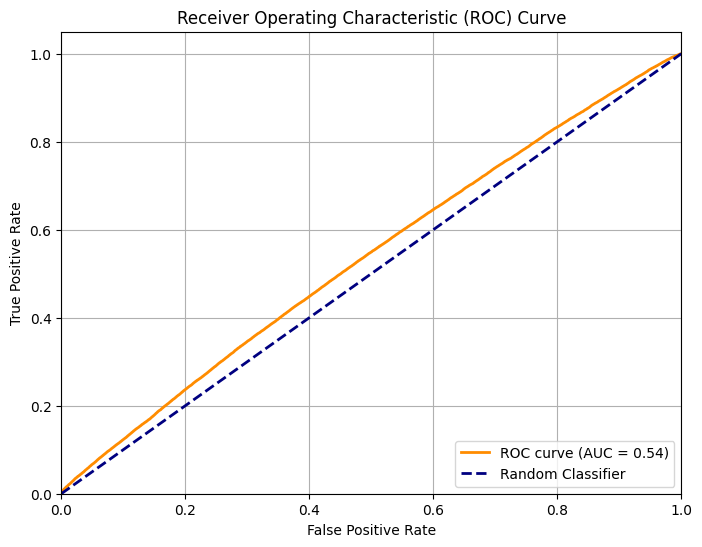

In [27]:
from sklearn.metrics import roc_curve, auc

#Get predicted probabilities for the positive class (class 1)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# 5. Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 2. Train Secondary Model - Random Forest

In [66]:
permno_list = data["PERMNO"].unique()

In [67]:
data_indexed = data.set_index(["Date", "PERMNO"], drop=False)
data_indexed = data_indexed.sort_index(level=0)

In [69]:
from Labeling import *

data_meta_dict = {}

for id in permno_list:
    data_sub = data_indexed.xs(id, level="PERMNO").sort_index()
    prices_sub = prices.xs(id, level="PERMNO").sort_index()
    labels = meta_labeling(data_sub, prices_sub["DlyClose"])
    labeled_events = pd.merge(data_sub, labels, left_index=True, right_index=True)
    data_meta_dict[id] = labeled_events

In [70]:
data_meta = pd.concat(data_meta_dict, ignore_index=True)

In [71]:
data_meta["Label"].value_counts()

Label
1.0    685513
0.0      8997
Name: count, dtype: int64

In [72]:
with open('./Data/stocks_side_label.pkl', 'wb') as file:
    pkl.dump(data, file)

# 3. Backtesting the Strategy

In [321]:
import numpy as np
import pandas as pd

def count_trading_days_per_event(
    trading_days: pd.DatetimeIndex,
    event_start: pd.Series | np.ndarray,
    event_end: pd.Series | np.ndarray,
) -> np.ndarray:
    """
    Count number of trading days between event_start and event_end for each event.

    trading_days: sorted DatetimeIndex of valid trading days
    event_start, event_end: same length, datetime-like (Series or array)
    """
    # Make sure these are arrays of Timestamps
    start_vals = pd.to_datetime(event_start).to_numpy()
    end_vals   = pd.to_datetime(event_end).to_numpy()

    # Position of first trading day >= start
    start_idx = trading_days.searchsorted(start_vals, side="left")

    # Position of last trading day <= end
    end_idx = trading_days.searchsorted(end_vals, side="right") - 1

    # Clip to valid range in case start/end are outside trading_days
    start_idx = np.clip(start_idx, 0, len(trading_days) - 1)
    end_idx   = np.clip(end_idx,   0, len(trading_days) - 1)

    # Number of trading days (if end before start, set to 0)
    n_days = end_idx - start_idx + 1
    n_days = np.where(n_days < 0, 0, n_days)

    return n_days


In [334]:
#invest into long/short/hold according to output probabiliteis of the model 

def compute_pl_for_stratgy(data, features , model , threshold = 0.5):

  label = model.predict(features)
  prob = np.max( model.predict_proba(features) , axis = 1) #returns the output probabiliy for class -1, 0, 1

  new_data = data.loc[features.index]
  new_data['pred_label'] = label
  new_data['prob'] = prob

  new_data = new_data[new_data['prob'] > threshold]

  #return of each event
  new_data["event_ret"] =  new_data['Return of Label'] * new_data['pred_label'] * new_data['prob'] #return daily returns. If investment horizon is longer then 1 day divide returns by size of investment window.

  #compute return of events in daily returns.
  new_data["event_days"] = count_trading_days_per_event(trading_days, new_data["Date"], new_data["End Time"])

  new_data["event_ret_dly"] = new_data["event_ret"] / new_data["event_days"]

  return new_data

In [335]:
new_data = compute_pl_for_stratgy(
    data=data,      # must contain 'Return of Label'
    features=X_test,
    model=rf,
    threshold=0.55,
)

In [336]:
new_data

,ticker,PERMNO,Date,DlyVol,DlyClose,DlyLow,DlyHigh,DlyOpen,SMA_20,SMA_50,...,Tomorrow_Return,End Time,Return of Label,Label,id,pred_label,prob,event_ret,event_days,event_ret_dly
555746,BGT,90302,2021-12-08,127260.0,14.32,14.1400,14.340,14.14,13.89200,13.653202,...,-0.002797,2021-12-13,-0.018156,-1.0,BGT90302,-1.0,0.566975,0.010294,4,0.002574
555749,BGT,90302,2021-12-23,43615.0,14.03,13.8000,14.070,13.86,13.95450,13.771802,...,0.001425,2021-12-28,0.019244,1.0,BGT90302,-1.0,0.564341,-0.010860,3,-0.003620
555757,BGT,90302,2022-01-21,178550.0,13.69,13.6707,14.050,14.01,13.91475,13.898900,...,-0.038724,2022-01-24,-0.037984,-1.0,BGT90302,-1.0,0.550612,0.020914,2,0.010457
555761,BGT,90302,2022-02-14,72698.0,13.29,13.2063,13.480,13.43,13.51900,13.767500,...,0.009734,2022-02-22,-0.027840,-1.0,BGT90302,-1.0,0.588360,0.016380,6,0.002730
555765,BGT,90302,2022-02-28,58689.0,12.81,12.6573,12.810,12.72,13.27200,13.571300,...,-0.003911,2022-03-07,-0.024980,-1.0,BGT90302,1.0,0.583831,-0.014584,6,-0.002431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694660,CBOE,93429,2023-10-27,821262.0,161.26,161.2600,164.880,164.40,161.55150,156.047200,...,0.013795,2023-10-30,0.013891,1.0,CBOE93429,1.0,0.565848,0.007860,2,0.003930
694661,CBOE,93429,2023-10-30,713977.0,163.50,162.0150,163.760,162.06,161.88650,156.314800,...,0.002382,2023-11-01,0.013333,1.0,CBOE93429,1.0,0.611401,0.008152,3,0.002717
694664,CBOE,93429,2023-11-03,1450496.0,169.50,162.3800,170.175,163.10,163.02700,157.564800,...,0.026662,2023-11-06,0.027021,1.0,CBOE93429,1.0,0.552491,0.014929,2,0.007464
694669,CBOE,93429,2023-11-30,1632329.0,182.19,179.8350,182.190,180.00,176.43650,166.878600,...,-0.010650,2023-12-01,-0.010593,-1.0,CBOE93429,1.0,0.646751,-0.006851,2,-0.003426


In [337]:
# Basic stats
correct = (new_data["Label"] == new_data["pred_label"]).sum()
accuracy   = correct/len(new_data["Label"])

mean_ret_daily = new_data["event_ret_dly"].mean()
mean_ret = new_data["event_ret"].mean()
event_std_ret  = new_data["event_ret"].std()
std_ret_daily = new_data["event_ret_dly"].std()
n_trades = len(new_data["event_ret"])


# Annualized Sharpe (assuming event frequency ~ daily)
sharpe = mean_ret_daily / std_ret_daily * np.sqrt(252) if std_ret_daily > 0 else np.nan

print(f"Out-of-sample trades: {n_trades}")
print(f"accuracy of predicted labels: {accuracy}")
print(f"Mean event return: {mean_ret:.6f}")
print(f"Mean daily event return: {mean_ret_daily:.6f}")
print(f"Std event return:  {std_ret_daily:.6f}")
print(f"Annualized Sharpe: {sharpe:.3f}")


Out-of-sample trades: 32681
accuracy of predicted labels: 0.543771610415838
Mean event return: 0.001939
Mean daily event return: 0.000698
Std event return:  0.029466
Annualized Sharpe: 0.376
